In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('Exploratory Data Analysis(eda)/data.csv',encoding='latin1')

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 转换日期格式
df['tdate'] = pd.to_datetime(df['tdate'], errors='coerce')

# 删除日期为空的行
df = df[df['tdate'].notna()]

# 按月度聚合 - 计算每月的任务数量
monthly_data = df.groupby(df['tdate'].dt.to_period('M')).size().reset_index(name='count')
monthly_data['date'] = monthly_data['tdate'].astype(str) + '-01'
monthly_data['date'] = pd.to_datetime(monthly_data['date'])
monthly_data = monthly_data[['date', 'count']].sort_values('date').reset_index(drop=True)

print(f"月度数据统计:")
print(f"总月份数: {len(monthly_data)}")
print(f"时间范围: {monthly_data['date'].min()} 到 {monthly_data['date'].max()}")
print(f"平均每月任务数: {monthly_data['count'].mean():.2f}")
print(f"每月任务数范围: {monthly_data['count'].min()} - {monthly_data['count'].max()}")
print("\n前5个月数据:")
print(monthly_data.head())
print("\n后5个月数据:")
print(monthly_data.tail())

月度数据统计:
总月份数: 138
时间范围: 2012-07-01 00:00:00 到 2023-12-01 00:00:00
平均每月任务数: 133.20
每月任务数范围: 62 - 233

前5个月数据:
        date  count
0 2012-07-01    136
1 2012-08-01    140
2 2012-09-01    105
3 2012-10-01     74
4 2012-11-01     93

后5个月数据:
          date  count
133 2023-08-01    183
134 2023-09-01    186
135 2023-10-01    166
136 2023-11-01    203
137 2023-12-01    171


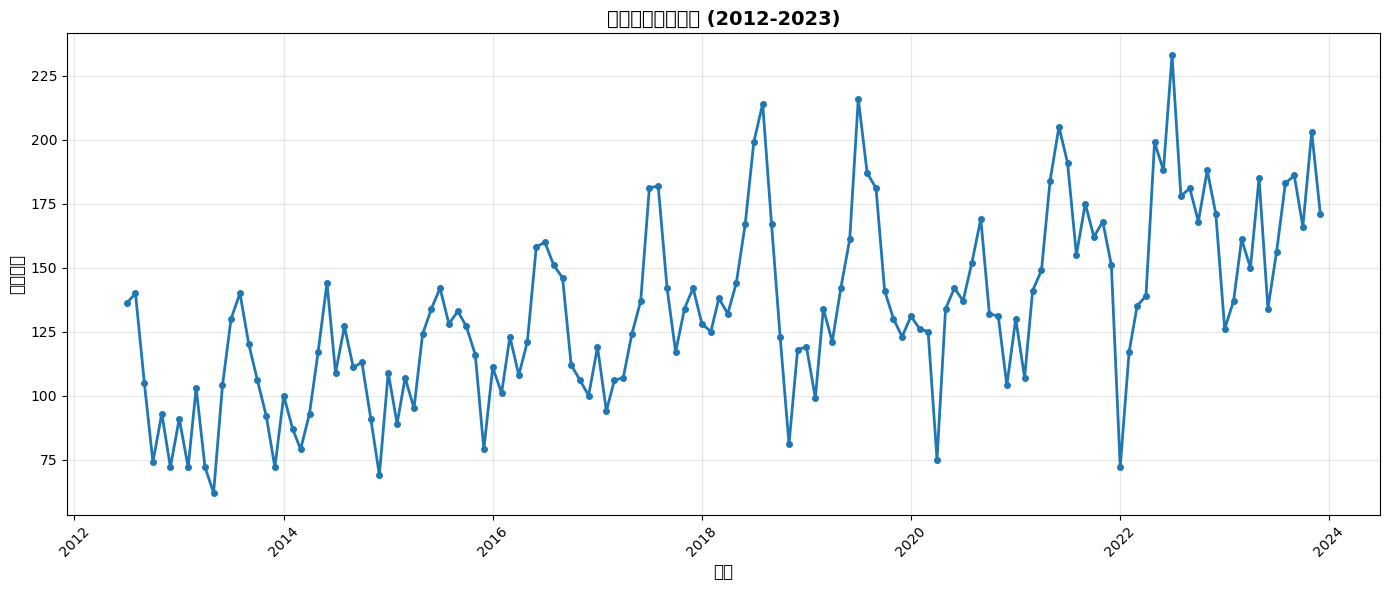


年度统计:
       sum        mean        std
date                             
2012   620  103.333333  29.540932
2013  1164   97.000000  24.852291
2014  1240  103.333333  21.089995
2015  1383  115.250000  19.725964
2016  1497  124.750000  22.696115
2017  1585  132.083333  27.523406
2018  1736  144.666667  36.755540
2019  1754  146.166667  33.795732
2020  1558  129.833333  23.280243
2021  1918  159.833333  27.222428
2022  1969  164.083333  42.455235
2023  1958  163.166667  23.728898


In [ ]:

plt.figure(figsize=(14, 6))
plt.plot(monthly_data['date'], monthly_data['count'], marker='o', linewidth=2, markersize=4)
plt.title('月度任务数量趋势 (2012-2023)', fontsize=14, fontweight='bold')
plt.xlabel('日期', fontsize=12)
plt.ylabel('任务数量', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 年度统计
yearly_stats = monthly_data.groupby(monthly_data['date'].dt.year)['count'].agg(['sum', 'mean', 'std'])
print("\n年度统计:")
print(yearly_stats)

15:00:49 - cmdstanpy - INFO - Chain [1] start processing
15:00:49 - cmdstanpy - INFO - Chain [1] done processing


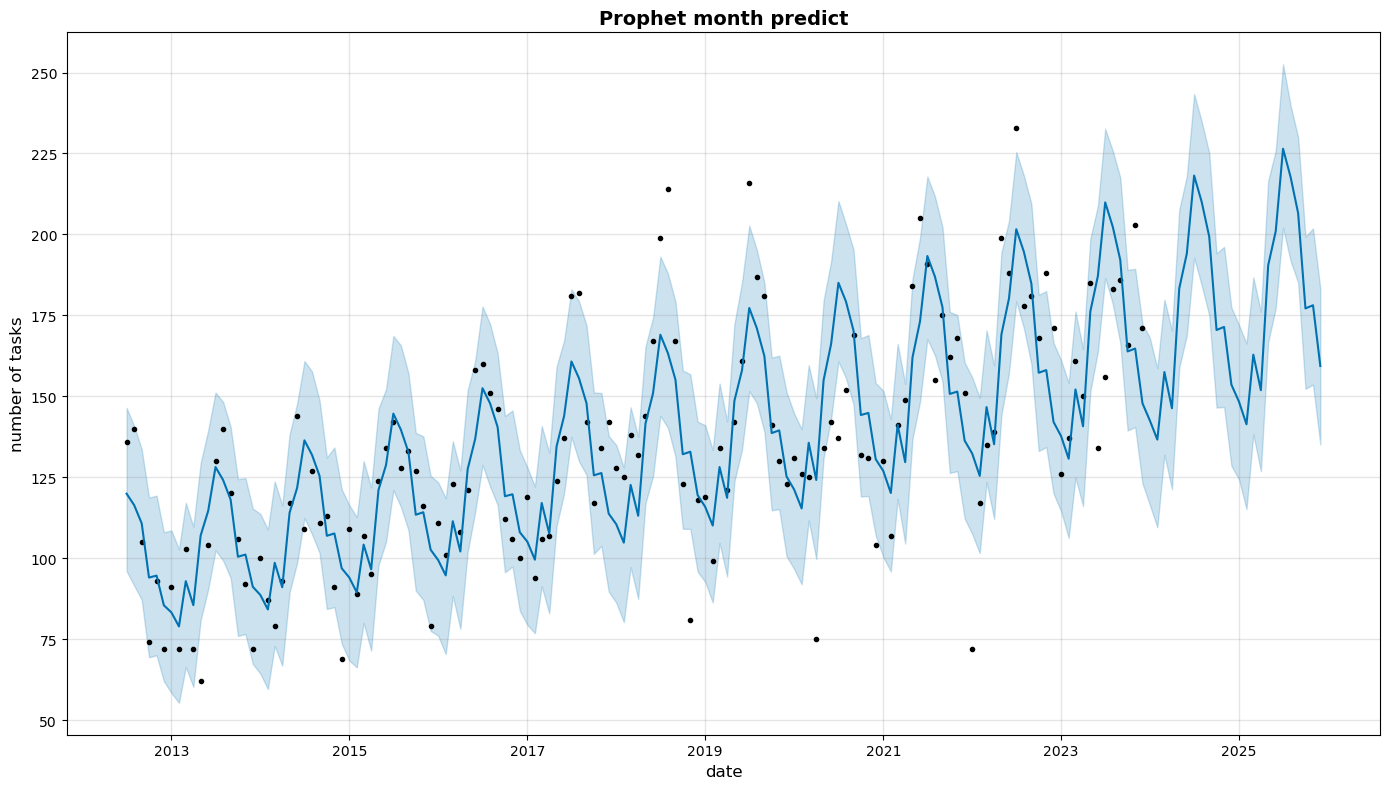


未来24个月预测:
        日期        预测值         下限         上限
2023-12-31 142.584654 116.507576 168.135924
2024-01-31 136.631136 109.552048 158.663309
2024-02-29 157.506278 131.981835 179.872243
2024-03-31 146.310796 121.310031 170.316825
2024-04-30 183.330339 158.869821 207.629583
2024-05-31 194.076975 168.795921 217.991071
2024-06-30 218.177073 192.792963 243.342898
2024-07-31 210.058879 184.293682 234.885203
2024-08-31 199.310251 174.994943 225.149972
2024-09-30 170.484748 146.522914 194.137007
2024-10-31 171.429210 146.717694 196.156971
2024-11-30 153.603891 128.564330 177.400870
2024-12-31 148.370911 124.366060 172.074434
2025-01-31 141.358880 115.185643 166.325286
2025-02-28 162.849214 138.266512 186.732791
2025-03-31 151.902631 126.861087 176.136058
2025-04-30 190.453929 166.775579 216.523115
2025-05-31 200.970216 177.211971 225.904737
2025-06-30 226.462005 202.069955 252.549507
2025-07-31 217.719124 191.834193 239.832270
2025-08-31 206.554370 185.083506 229.965816
2025-09-30 177.142351

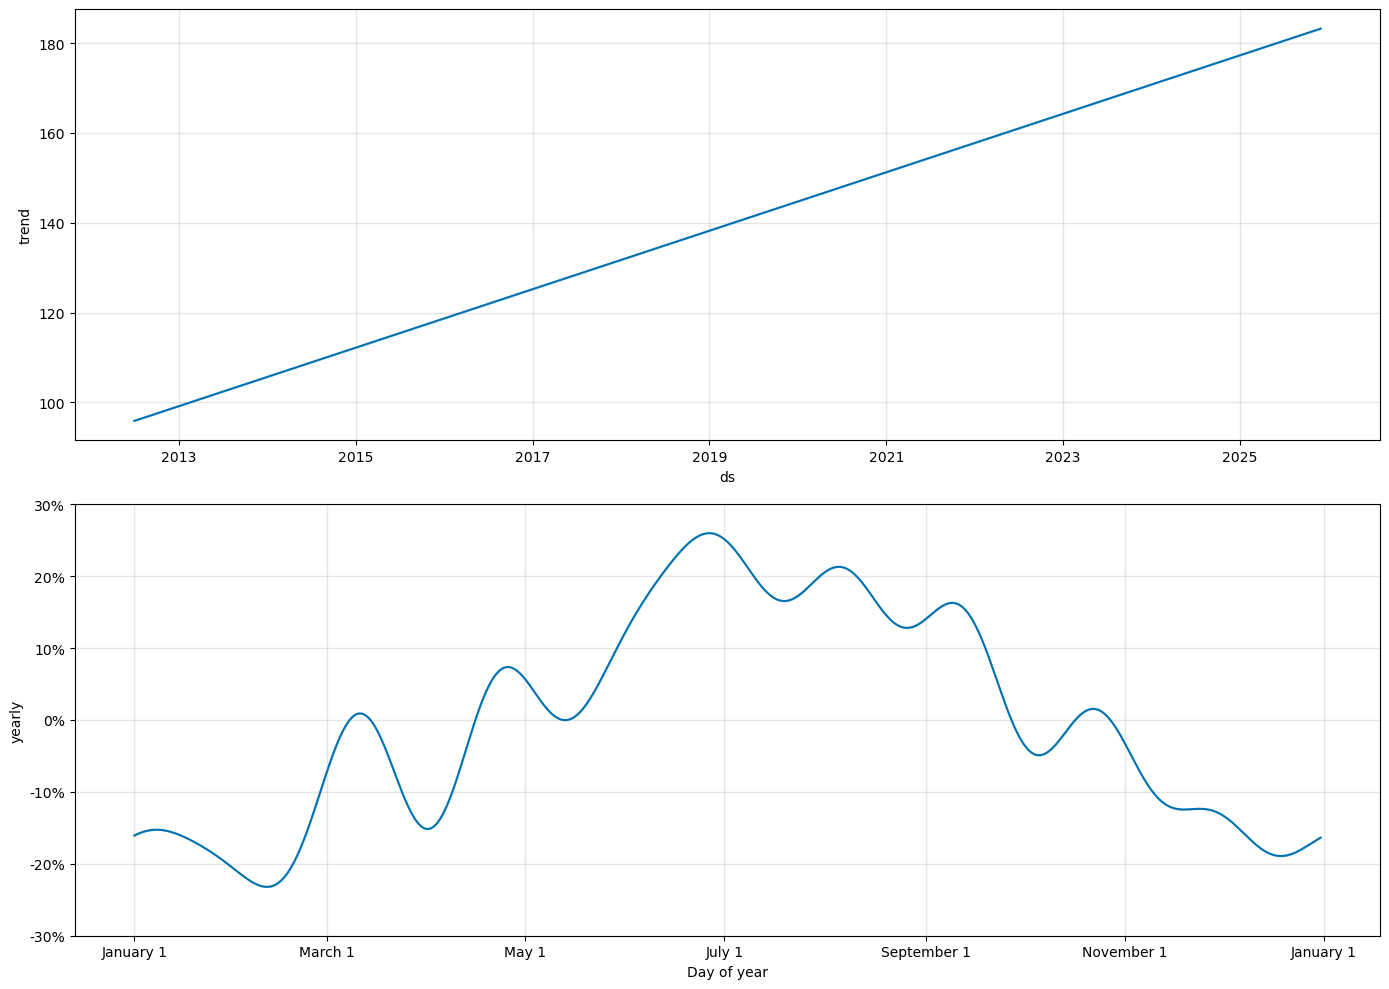

In [ ]:

try:
    from prophet import Prophet
    use_prophet = True
except ImportError:
    print("Prophet 未安装，将使用 ARIMA 模型")
    print("安装命令: pip install prophet")
    use_prophet = False

if use_prophet:
    # 准备 Prophet 格式的数据
    prophet_data = monthly_data[['date', 'count']].copy()
    prophet_data.columns = ['ds', 'y']
    
    # 创建并训练模型
    model = Prophet(
        yearly_seasonality=True,      # 年度季节性
        weekly_seasonality=False,      # 周季节性（月度数据不需要）
        daily_seasonality=False,       # 日季节性
        seasonality_mode='multiplicative',  # 乘法季节性
        changepoint_prior_scale=0.05    # 趋势变化敏感度
    )
    
    model.fit(prophet_data)
    
    # 预测未来24个月（2年）
    future = model.make_future_dataframe(periods=24, freq='M')
    forecast = model.predict(future)
    
    # 可视化结果
    fig = model.plot(forecast, figsize=(14, 8))
    plt.title('Prophet month predict', fontsize=14, fontweight='bold')
    plt.xlabel('date', fontsize=12)
    plt.ylabel('number of tasks', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # 显示预测结果
    print("\n未来24个月预测:")
    future_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(24)
    future_forecast.columns = ['日期', '预测值', '下限', '上限']
    print(future_forecast.to_string(index=False))
    
    # 显示组件（趋势和季节性）
    fig2 = model.plot_components(forecast, figsize=(14, 10))
    plt.tight_layout()
    plt.show()

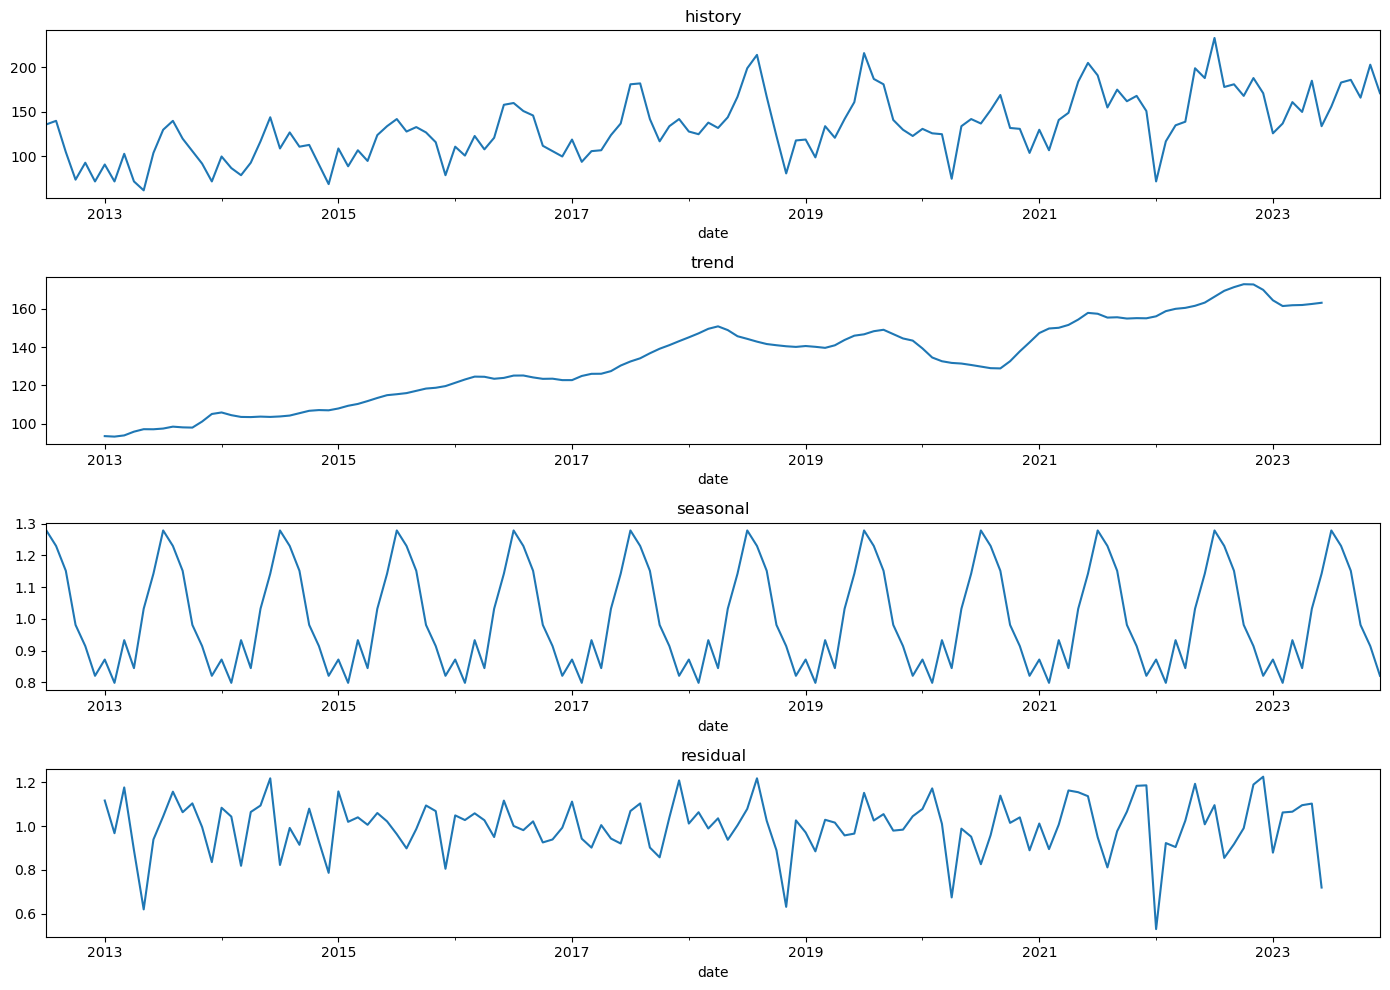

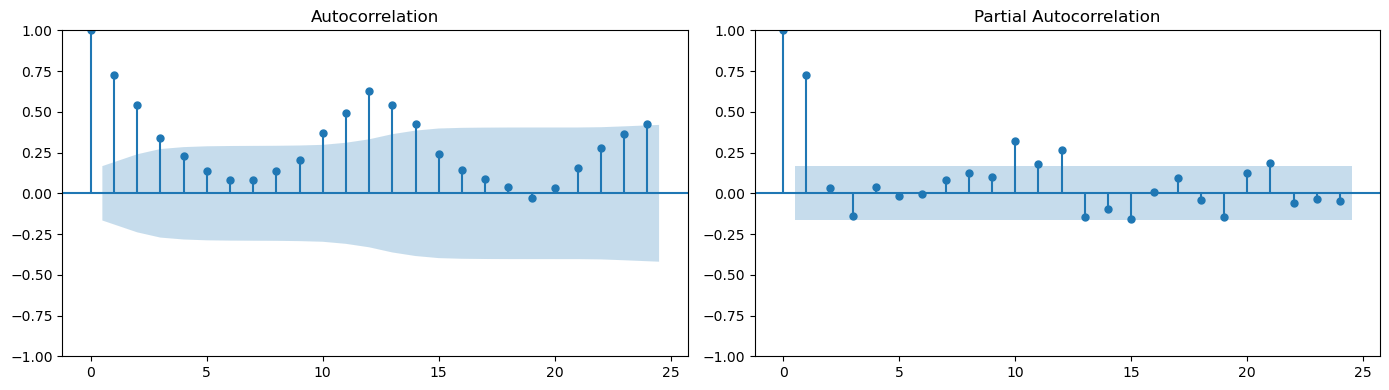

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



ARIMA 模型摘要:
                                    SARIMAX Results                                     
Dep. Variable:                            count   No. Observations:                  138
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -556.852
Date:                          Wed, 12 Nov 2025   AIC                           1123.703
Time:                                  15:02:39   BIC                           1137.845
Sample:                              07-01-2012   HQIC                          1129.448
                                   - 12-01-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3969      0.088      4.527      0.000       0.225       0.569
ma.L1         -0.9998      4.176     -

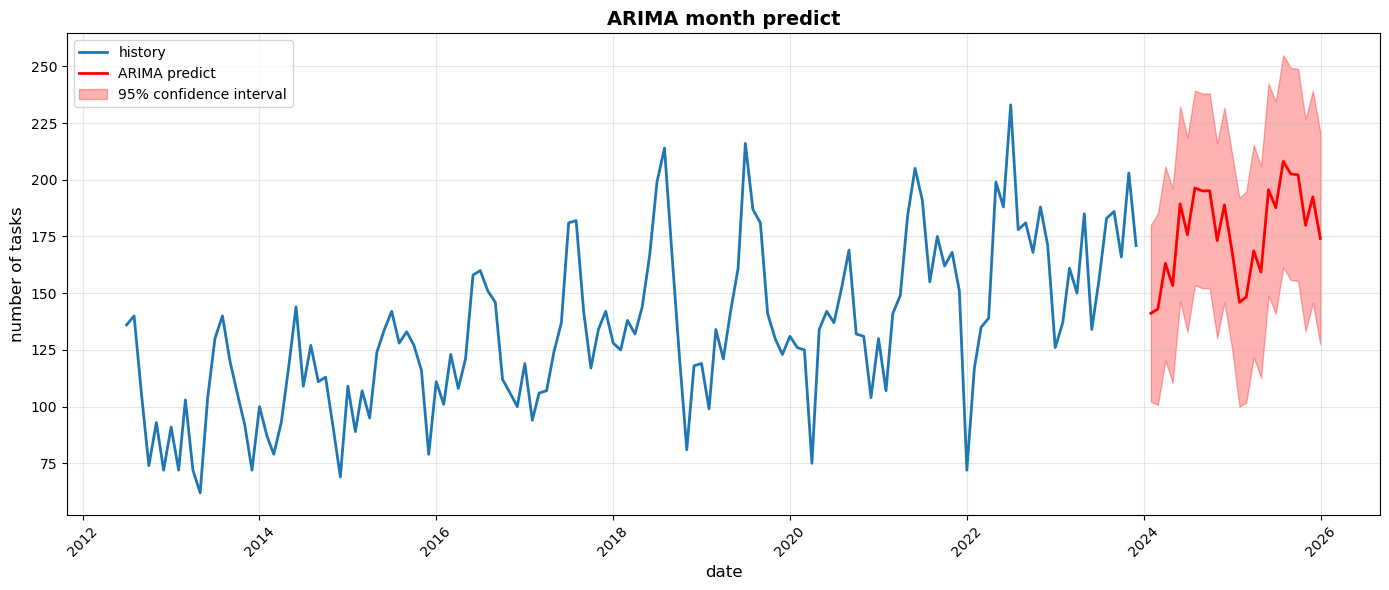


ARIMA 未来24个月预测:
        日期        预测值         下限         上限
2024-01-31 141.118586 102.104874 180.132297
2024-02-29 143.027985 100.862700 185.193270
2024-03-31 163.154734 120.439376 205.870092
2024-04-30 153.367787 110.536224 196.199350
2024-05-31 189.382045 146.518765 232.245325
2024-06-30 175.754762 132.877847 218.631678
2024-07-31 196.392915 153.504529 239.281300
2024-08-31 195.061704 152.172045 237.951364
2024-09-30 195.150058 152.259900 238.040217
2024-10-31 173.168167 130.277809 216.058526
2024-11-30 188.928525 146.038081 231.818969
2024-12-31 168.832536 125.942043 211.723028
2025-01-31 145.948281  99.954645 191.941917
2025-02-28 148.359167 101.796597 194.921736
2025-03-31 168.645045 121.953976 215.336115
2025-04-30 159.336069 112.608210 206.063929
2025-05-31 195.620398 148.877938 242.362858
2025-06-30 187.675774 140.922379 234.429169
2025-07-31 208.126999 161.358474 254.895524
2025-08-31 202.530489 155.761307 249.299671
2025-09-30 202.182645 155.413200 248.952091
2025-10-31 179.

In [ ]:

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 设置时间序列索引
ts = monthly_data.set_index('date')['count']

# 时间序列分解
decomposition = seasonal_decompose(ts, model='multiplicative', period=12)
fig, axes = plt.subplots(4, 1, figsize=(14, 10))
decomposition.observed.plot(ax=axes[0], title='history')
decomposition.trend.plot(ax=axes[1], title='trend')
decomposition.seasonal.plot(ax=axes[2], title='seasonal')
decomposition.resid.plot(ax=axes[3], title='residual')
plt.tight_layout()
plt.show()

# ACF 和 PACF 图（用于确定 ARIMA 参数）
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(ts, lags=24, ax=axes[0])
plot_pacf(ts, lags=24, ax=axes[1])
plt.tight_layout()
plt.show()

# 拟合 ARIMA 模型 (p, d, q) x (P, D, Q, s)
# 这里使用自动选择参数，你也可以手动调整
try:
    # 尝试 SARIMA 模型（季节性 ARIMA）
    model_arima = ARIMA(ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    fitted_model = model_arima.fit()
    
    print("\nARIMA 模型摘要:")
    print(fitted_model.summary())
    
    # 预测未来24个月
    forecast_arima = fitted_model.forecast(steps=24)
    forecast_ci = fitted_model.get_forecast(steps=24).conf_int()
    
    # 可视化 ARIMA 预测
    plt.figure(figsize=(14, 6))
    plt.plot(ts.index, ts.values, label='history', linewidth=2)
    
    # 创建未来日期
    last_date = ts.index[-1]
    future_dates = pd.date_range(start=last_date, periods=25, freq='M')[1:]
    
    plt.plot(future_dates, forecast_arima, label='ARIMA predict', linewidth=2, color='red')
    plt.fill_between(future_dates, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], 
                     alpha=0.3, color='red', label='95% confidence interval')
    plt.title('ARIMA month predict', fontsize=14, fontweight='bold')
    plt.xlabel('date', fontsize=12)
    plt.ylabel('number of tasks', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 显示预测结果
    arima_forecast_df = pd.DataFrame({
        '日期': future_dates,
        '预测值': forecast_arima,
        '下限': forecast_ci.iloc[:, 0],
        '上限': forecast_ci.iloc[:, 1]
    })
    print("\nARIMA 未来24个月预测:")
    print(arima_forecast_df.to_string(index=False))
    
except Exception as e:
    print(f"ARIMA 模型拟合出错: {e}")
    print("尝试使用更简单的模型...")

训练集: 114 个月 (2012-07-01 00:00:00 到 2021-12-01 00:00:00)
测试集: 12 个月 (2022-01-01 00:00:00 到 2022-12-01 00:00:00)
测试集月份数: 12


15:24:51 - cmdstanpy - INFO - Chain [1] start processing
15:24:51 - cmdstanpy - INFO - Chain [1] done processing


训练集: 114 个月 (2012-07-01 00:00:00 到 2021-12-01 00:00:00)
测试集: 12 个月 (2022-01-01 00:00:00 到 2022-12-01 00:00:00)
测试集月份数: 12
警告: 使用year_month匹配到 11 条数据，改用最后12行

测试集预测值数量: 11
测试集实际值数量: 11

Prophet 模型评估 (2022年):
MAE (平均绝对误差): 25.30
RMSE (均方根误差): 29.95
MAPE (平均绝对百分比误差): 18.85%


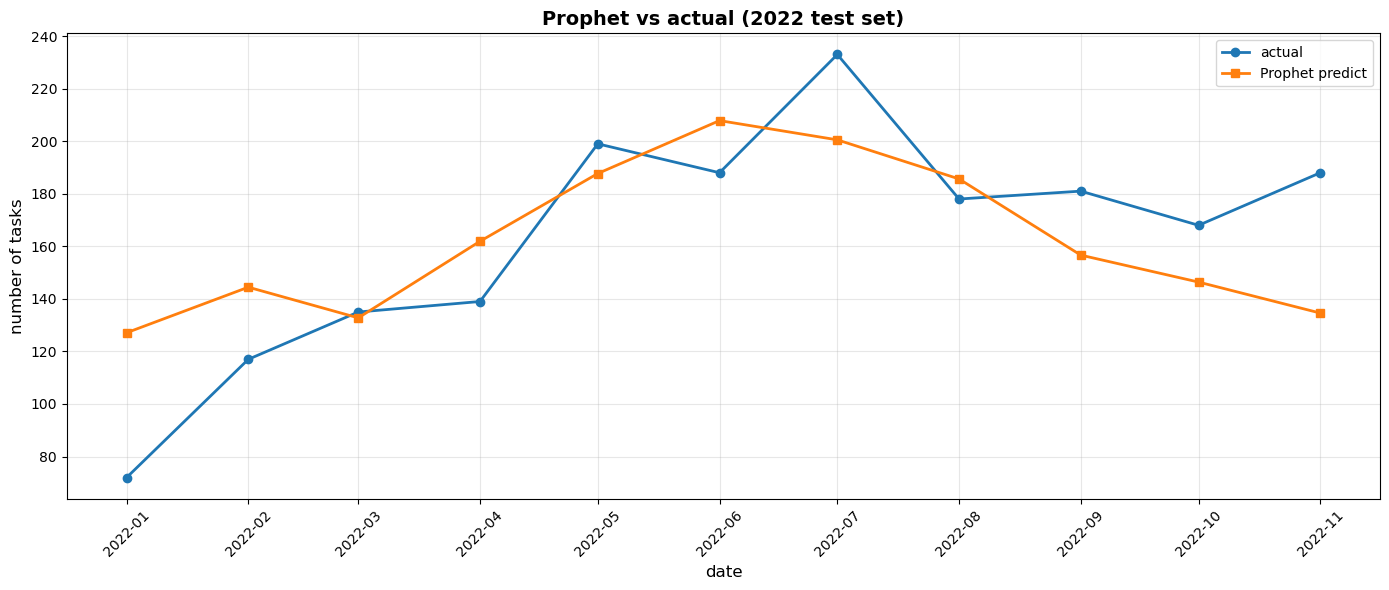

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



ARIMA 模型评估 (2022年):
MAE (平均绝对误差): 23.11
RMSE (均方根误差): 31.96
MAPE (平均绝对百分比误差): nan%


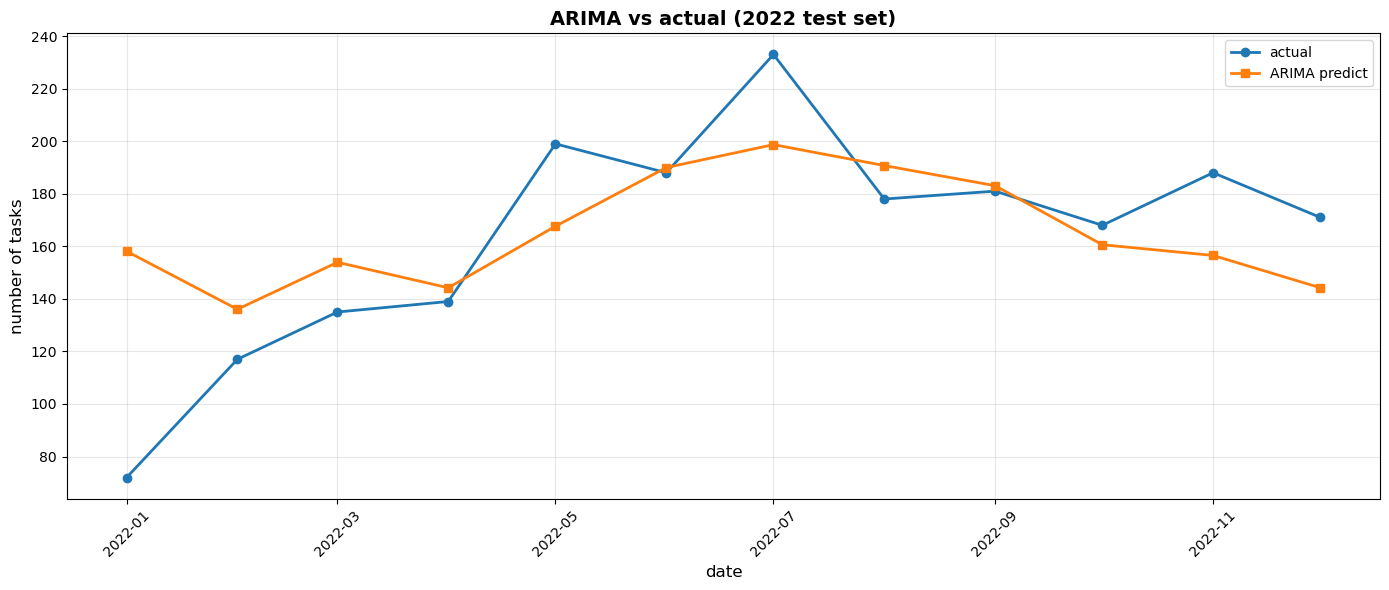

In [ ]:


from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# 将数据分为训练集和测试集（2022年作为测试集）
# 训练集：2012-2021年
# 测试集：2022年

train_data = monthly_data[monthly_data['date'].dt.year < 2022].copy()
test_data = monthly_data[monthly_data['date'].dt.year == 2022].copy()

print(f"训练集: {len(train_data)} 个月 ({train_data['date'].min()} 到 {train_data['date'].max()})")
print(f"测试集: {len(test_data)} 个月 ({test_data['date'].min()} 到 {test_data['date'].max()})")
print(f"测试集月份数: {len(test_data)}")

# 评估 Prophet 模型（如果可用）
if use_prophet:
    # 在训练集上训练
    train_prophet = train_data[['date', 'count']].copy()
    train_prophet.columns = ['ds', 'y']
    
    model_train = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')
    model_train.fit(train_prophet)
    
    # 预测测试集期间（2022年的12个月）
    # 计算需要预测的月份数
    months_to_predict = len(test_data)
    
    # 创建未来数据框
    future_test = model_train.make_future_dataframe(periods=months_to_predict, freq='M')
    forecast_test = model_train.predict(future_test)
    
    # 方法1：直接使用最后N行（N=测试集长度），因为Prophet会按顺序生成预测
    # 获取训练集的最后日期
    last_train_date = train_data['date'].max()
    
    # 从forecast_test中提取2022年的预测值
    # 将日期转换为年月格式进行比较
    forecast_test['year_month'] = forecast_test['ds'].dt.to_period('M')
    test_data['year_month'] = test_data['date'].dt.to_period('M')
    
    # 匹配2022年的数据
    test_forecast_df = forecast_test[forecast_test['year_month'].isin(test_data['year_month'])].copy()
    
    # 如果还是匹配不到，使用最后N行
    if len(test_forecast_df) == 0 or len(test_forecast_df) != len(test_data):
        print(f"警告: 使用year_month匹配到 {len(test_forecast_df)} 条数据，改用最后{months_to_predict}行")
        test_forecast_df = forecast_test[['ds', 'yhat']].tail(months_to_predict).copy()
        test_forecast_df['year_month'] = test_forecast_df['ds'].dt.to_period('M')
    
    # 合并数据，确保顺序一致
    test_data_with_forecast = test_data.merge(
        test_forecast_df[['year_month', 'yhat']],
        on='year_month',
        how='inner'
    )
    
    # 如果合并后数据为空，尝试更宽松的匹配
    if len(test_data_with_forecast) == 0:
        print("警告: 合并失败，尝试直接使用索引匹配")
        # 直接使用最后N行，并手动对齐
        test_forecast_values = forecast_test['yhat'].tail(months_to_predict).values
        test_actual_values = test_data['count'].values
        
        # 确保长度一致
        min_len = min(len(test_forecast_values), len(test_actual_values))
        test_forecast = test_forecast_values[:min_len]
        test_actual = test_actual_values[:min_len]
    else:
        # 按日期排序
        test_data_with_forecast = test_data_with_forecast.sort_values('date')
        
        # 提取预测值和实际值
        test_forecast = test_data_with_forecast['yhat'].values
        test_actual = test_data_with_forecast['count'].values
    
    print(f"\n测试集预测值数量: {len(test_forecast)}")
    print(f"测试集实际值数量: {len(test_actual)}")
    
    # 最终检查：确保有数据且长度一致
    if len(test_forecast) == 0 or len(test_actual) == 0:
        print("错误: 无法匹配预测值和实际值，请检查日期格式")
        print(f"Forecast dates: {forecast_test['ds'].tail(15).tolist()}")
        print(f"Test dates: {test_data['date'].tolist()}")
    else:
        # 确保长度一致
        min_len = min(len(test_forecast), len(test_actual))
        test_forecast = test_forecast[:min_len]
        test_actual = test_actual[:min_len]
        
        # 计算评估指标
        mae_prophet = mean_absolute_error(test_actual, test_forecast)
        rmse_prophet = math.sqrt(mean_squared_error(test_actual, test_forecast))
        mape_prophet = np.mean(np.abs((test_actual - test_forecast) / test_actual)) * 100
        
        print("\nProphet 模型评估 (2022年):")
        print(f"MAE (平均绝对误差): {mae_prophet:.2f}")
        print(f"RMSE (均方根误差): {rmse_prophet:.2f}")
        print(f"MAPE (平均绝对百分比误差): {mape_prophet:.2f}%")
        
        # 可视化预测 vs 实际
        test_dates = test_data_with_forecast['date'].values[:min_len] if 'test_data_with_forecast' in locals() and len(test_data_with_forecast) > 0 else test_data['date'].values[:min_len]
        
        plt.figure(figsize=(14, 6))
        plt.plot(test_dates, test_actual, 'o-', label='actual', linewidth=2, markersize=6)
        plt.plot(test_dates, test_forecast, 's-', label='Prophet predict', linewidth=2, markersize=6)
        plt.title('Prophet vs actual (2022 test set)', fontsize=14, fontweight='bold')
        plt.xlabel('date', fontsize=12)
        plt.ylabel('number of tasks', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# 评估 ARIMA 模型
try:
    train_ts = train_data.set_index('date')['count']
    model_arima_train = ARIMA(train_ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    fitted_arima_train = model_arima_train.fit()
    
    # 预测测试集（2022年的12个月）
    forecast_arima_test = fitted_arima_train.forecast(steps=len(test_data))
    
    mae_arima = mean_absolute_error(test_data['count'], forecast_arima_test)
    rmse_arima = math.sqrt(mean_squared_error(test_data['count'], forecast_arima_test))
    mape_arima = np.mean(np.abs((test_data['count'] - forecast_arima_test) / test_data['count'])) * 100
    
    print("\nARIMA 模型评估 (2022年):")
    print(f"MAE (平均绝对误差): {mae_arima:.2f}")
    print(f"RMSE (均方根误差): {rmse_arima:.2f}")
    print(f"MAPE (平均绝对百分比误差): {mape_arima:.2f}%")
    
    # 可视化预测 vs 实际
    plt.figure(figsize=(14, 6))
    plt.plot(test_data['date'], test_data['count'], 'o-', label='actual', linewidth=2, markersize=6)
    plt.plot(test_data['date'], forecast_arima_test.values, 's-', label='ARIMA predict', linewidth=2, markersize=6)
    plt.title('ARIMA vs actual (2022 test set)', fontsize=14, fontweight='bold')
    plt.xlabel('date', fontsize=12)
    plt.ylabel('number of tasks', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"ARIMA 评估出错: {e}")
    import traceback
    traceback.print_exc()


In [21]:
monthly_data

,date,count
0,2012-07-01,136
1,2012-08-01,140
2,2012-09-01,105
3,2012-10-01,74
4,2012-11-01,93
...,...,...
133,2023-08-01,183
134,2023-09-01,186
135,2023-10-01,166
136,2023-11-01,203


In [29]:
df_2018 = monthly_data[monthly_data['date'].dt.year == 2018]
df_2020 = monthly_data[monthly_data['date'].dt.year == 2020]
df_2021 = monthly_data[monthly_data['date'].dt.year == 2021]
df_2022 = monthly_data[monthly_data['date'].dt.year == 2022]
df_2023 = monthly_data[monthly_data['date'].dt.year == 2023]

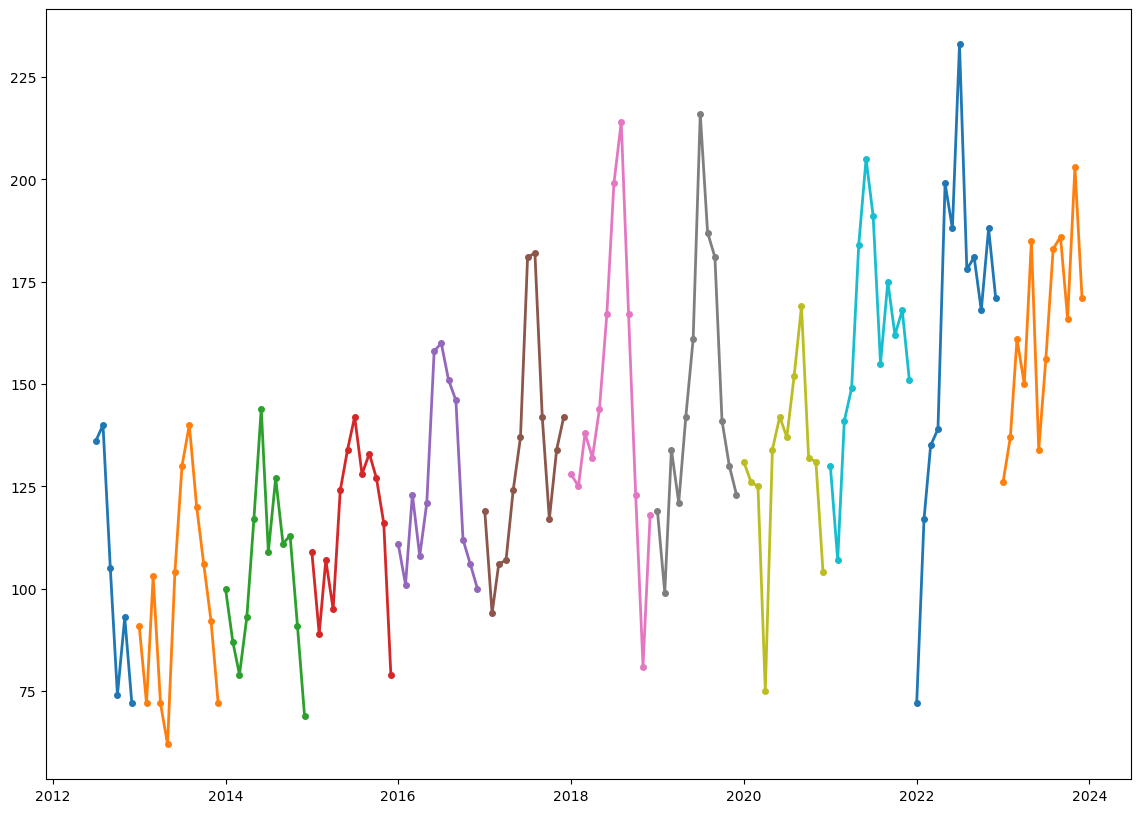

In [ ]:
plt.figure(figsize=(14, 10))
for year in range(2012, 2024):
    df_year = monthly_data[monthly_data['date'].dt.year == year]
    plt.plot(df_year['date'], df_year['count'], marker='o', linewidth=2, markersize=4)
plt.show()

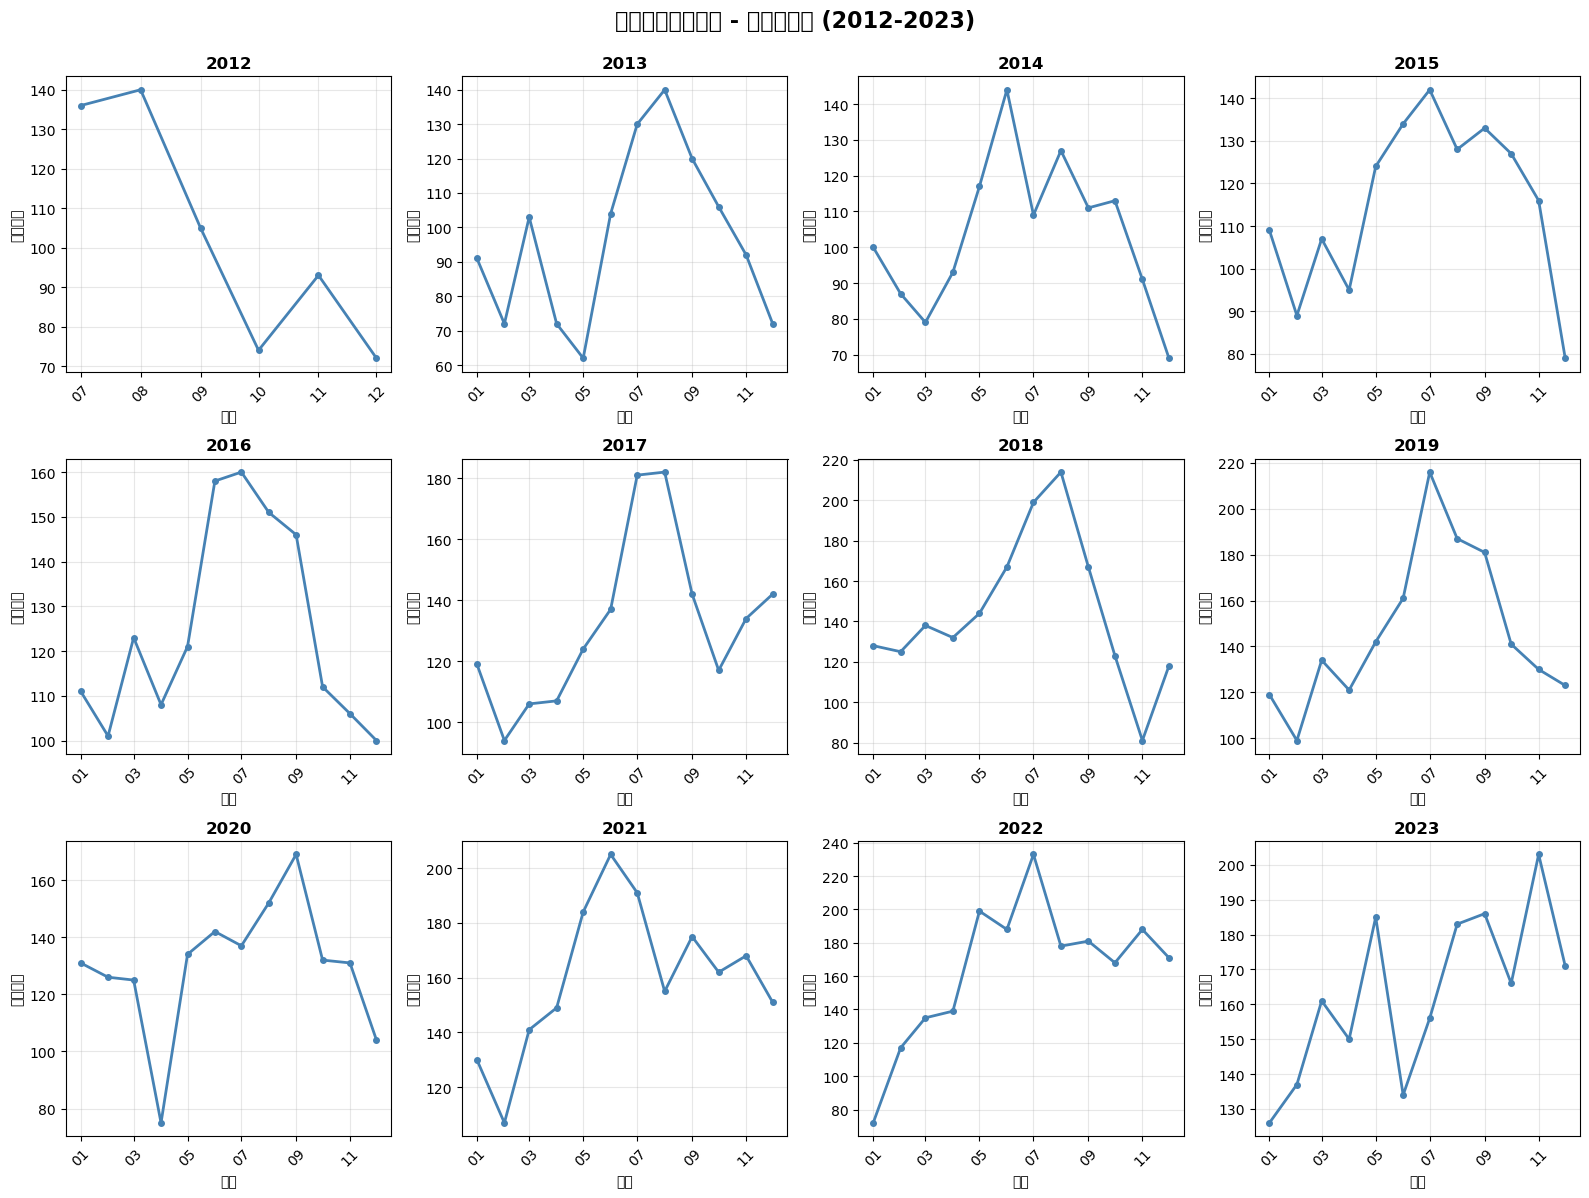

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 计算需要的子图布局（3行4列，共12年）
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('月度任务数量趋势 - 按年度分图 (2012-2023)', fontsize=16, fontweight='bold', y=0.995)

# 将 axes 展平为一维数组，方便遍历
axes = axes.flatten()

years = range(2012, 2024)
for idx, year in enumerate(years):
    df_year = monthly_data[monthly_data['date'].dt.year == year]
    
    if len(df_year) > 0:
        axes[idx].plot(df_year['date'], df_year['count'], marker='o', linewidth=2, markersize=4, color='steelblue')
        axes[idx].set_title(f'{year}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('月份', fontsize=10)
        axes[idx].set_ylabel('任务数量', fontsize=10)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45)
        
        # 设置 x 轴格式为月份
        axes[idx].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m'))
    else:
        axes[idx].text(0.5, 0.5, f'{year}年\n无数据', ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f'{year}年', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
import requests
years = range(2012, 2024)  # 2012 到 2023 inclusive
API_KEY = '44b467ab29b78c3c2b06b200a838a102c5a11bfa'
results = []
for yr in years:
    url = f"https://api.census.gov/data/{yr}/acs/acs1?get=NAME,B01003_001E&for=state:23"
    resp = requests.get(url)
    if resp.status_code == 200:
        data = resp.json()
        # 第一行是字段名，再之后是数据行
        results.append((yr, data))
    else:
        if yr == 2020:
            results.append((2020,[['NAME', 'B01003_001E', 'state'], ['Maine', '1362359', '23']]))
        print(f"Year {yr} failed: {resp.status_code}")


Year 2020 failed: 404


In [73]:
#把results存入csv
df = pd.DataFrame(results, columns=['year', 'population'])
df.to_csv('population_data.csv', index=False)


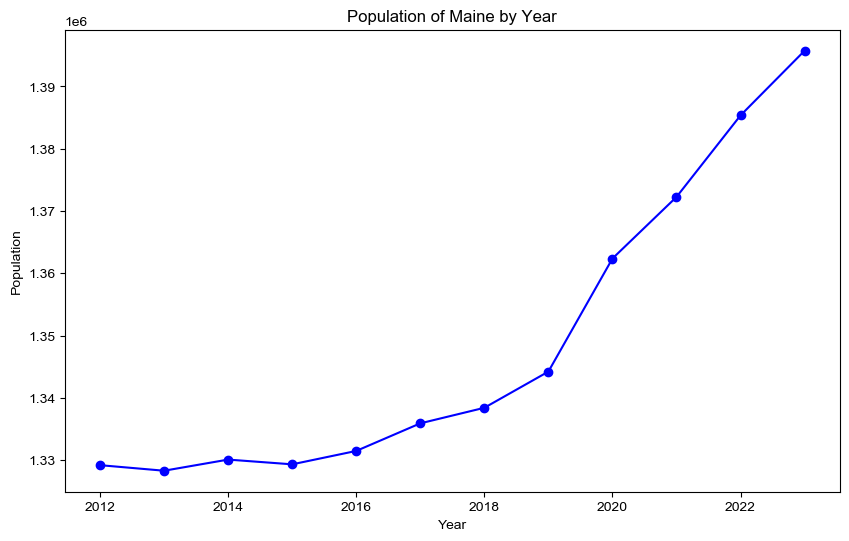

In [72]:
# 把results放入dict
results_dict = {}
for yr, data in results:
    results_dict[int(yr)] = int(data[1][1])
# 把results_dict画折线图
plt.figure(figsize=(10, 6))
plt.plot(years, [results_dict[yr] for yr in years], marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Population of Maine by Year')
plt.show()



美国人口数据:
        date  population_millions
0 2012-07-01         1.328747e+06
1 2012-08-01         1.328673e+06
2 2012-09-01         1.328599e+06
3 2012-10-01         1.328524e+06
4 2012-11-01         1.328450e+06
5 2012-12-01         1.328376e+06
6 2013-01-01         1.328302e+06
7 2013-02-01         1.328451e+06
8 2013-03-01         1.328600e+06
9 2013-04-01         1.328749e+06

人口数据范围: 2012-07-01 00:00:00 到 2023-12-01 00:00:00
人口范围: 1328302.00 - 1394856.83 百万

合并后数据:
总月份数: 138
        date  count  population_millions
0 2012-07-01    136         1.328747e+06
1 2012-08-01    140         1.328673e+06
2 2012-09-01    105         1.328599e+06
3 2012-10-01     74         1.328524e+06
4 2012-11-01     93         1.328450e+06
5 2012-12-01     72         1.328376e+06
6 2013-01-01     91         1.328302e+06
7 2013-02-01     72         1.328451e+06
8 2013-03-01    103         1.328600e+06
9 2013-04-01     72         1.328749e+06
          date  count  population_millions
128 2023-03-01    161 

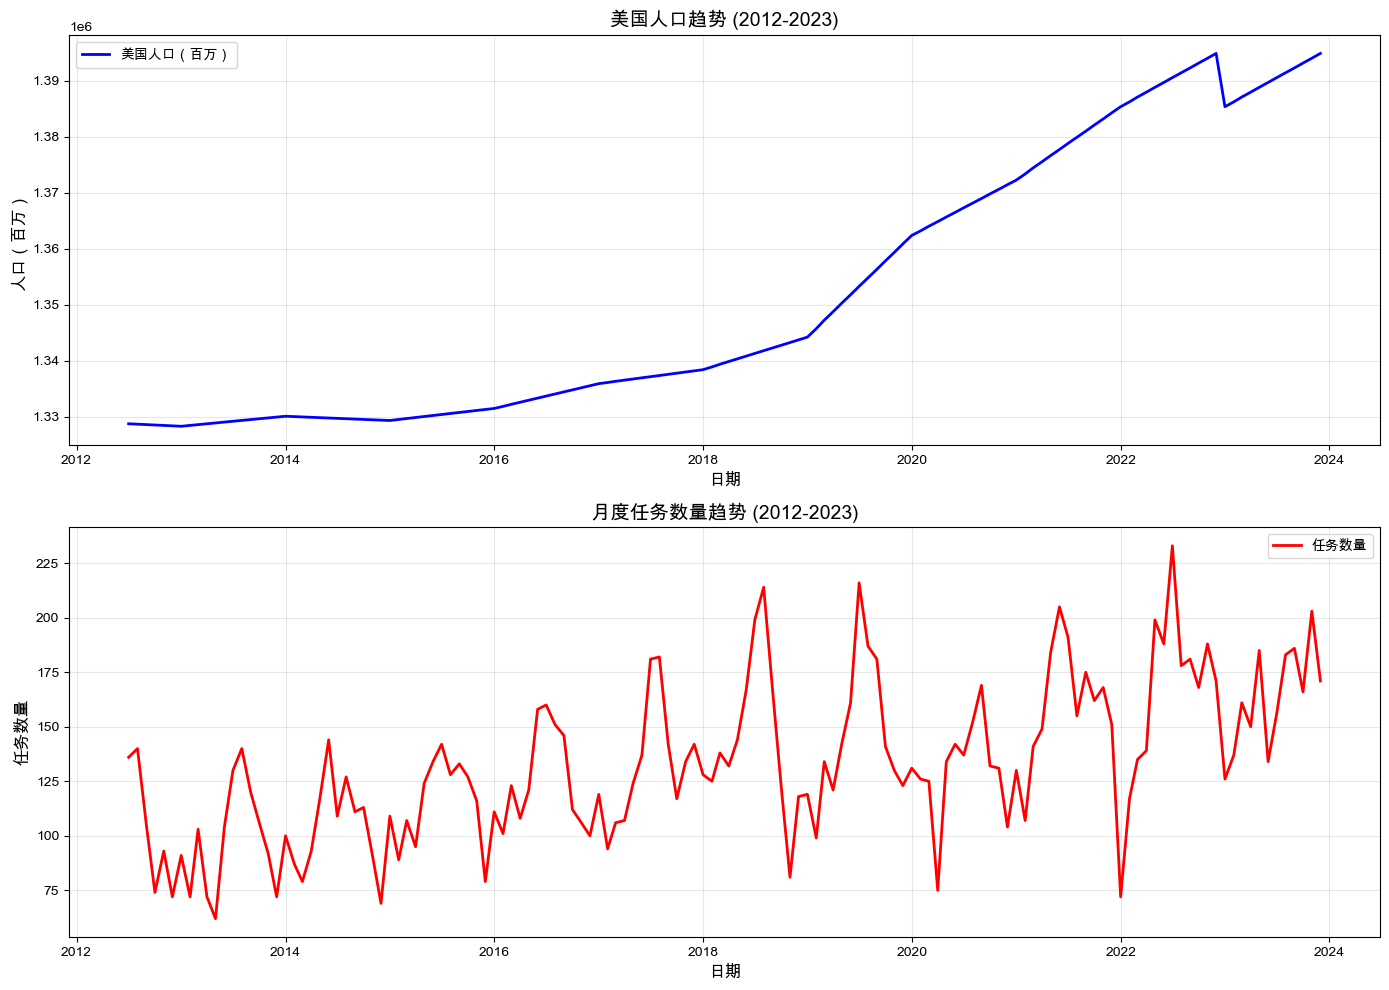

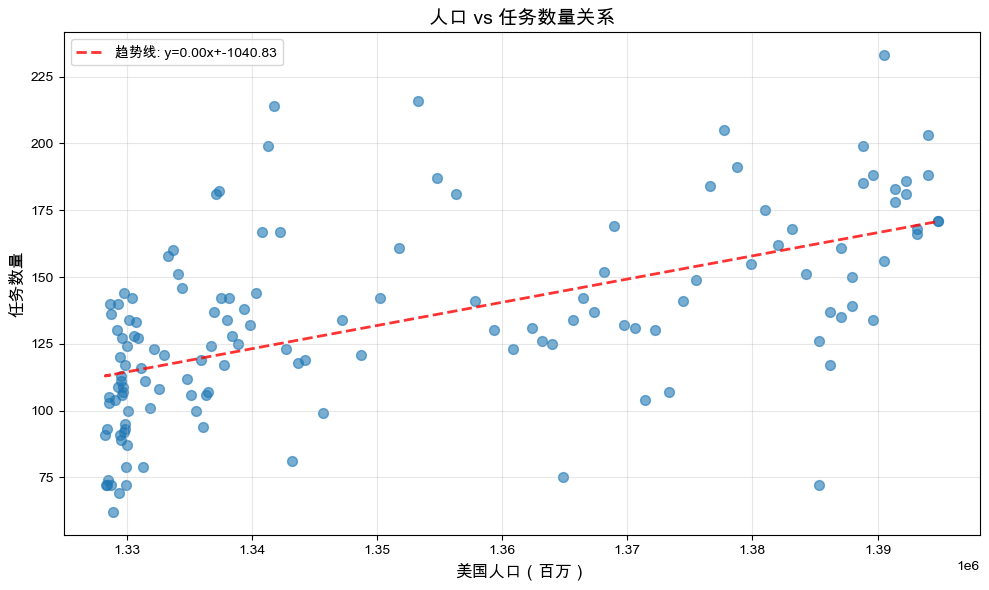


人口与任务数量的相关系数: 0.5760


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

def get_us_population_data():
    population_data = results_dict
    
    # 创建年度人口DataFrame
    pop_df = pd.DataFrame(list(population_data.items()), columns=['year', 'population_millions'])
    
    # 为每月插值人口数据（假设线性增长）
    monthly_pop = []
    for year in range(2012, 2024):
        if year == 2012:
            # 2012年使用2012和2013年的平均值作为起点
            start_pop = population_data[2012]
            end_pop = population_data[2013]
        elif year == 2023:
            # 2023年使用2022和2023年的数据
            start_pop = population_data[2022]
            end_pop = population_data[2023]
        else:
            start_pop = population_data[year]
            end_pop = population_data[year + 1]
        
        # 计算每月的人口增长
        monthly_growth = (end_pop - start_pop) / 12
        
        # 生成12个月的数据
        for month in range(1, 13):
            if year == 2012 and month < 7:
                continue  # 数据从2012年7月开始
            if year == 2023 and month > 12:
                break
            pop_value = start_pop + (month - 1) * monthly_growth
            monthly_pop.append({
                'year': year,
                'month': month,
                'population_millions': pop_value
            })
    
    monthly_pop_df = pd.DataFrame(monthly_pop)
    monthly_pop_df['date'] = pd.to_datetime(monthly_pop_df[['year', 'month']].assign(day=1))
    
    return monthly_pop_df[['date', 'population_millions']]

# 获取人口数据
population_df = get_us_population_data()
print("美国人口数据:")
print(population_df.head(10))
print(f"\n人口数据范围: {population_df['date'].min()} 到 {population_df['date'].max()}")
print(f"人口范围: {population_df['population_millions'].min():.2f} - {population_df['population_millions'].max():.2f} 百万")

# 合并人口数据和任务数据
merged_data = monthly_data.merge(
    population_df,
    on='date',
    how='inner'
)

print(f"\n合并后数据:")
print(f"总月份数: {len(merged_data)}")
print(merged_data.head(10))
print(merged_data.tail(10))

# 可视化人口和任务数量的关系
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 上图：人口趋势
axes[0].plot(merged_data['date'], merged_data['population_millions'], 'b-', linewidth=2, label='美国人口（百万）')
axes[0].set_title('美国人口趋势 (2012-2023)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('日期', fontsize=12)
axes[0].set_ylabel('人口（百万）', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# 下图：任务数量趋势
axes[1].plot(merged_data['date'], merged_data['count'], 'r-', linewidth=2, label='任务数量')
axes[1].set_title('月度任务数量趋势 (2012-2023)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('日期', fontsize=12)
axes[1].set_ylabel('任务数量', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# 散点图：人口 vs 任务数量
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['population_millions'], merged_data['count'], alpha=0.6, s=50)
plt.xlabel('美国人口（百万）', fontsize=12)
plt.ylabel('任务数量', fontsize=12)
plt.title('人口 vs 任务数量关系', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 添加趋势线
z = np.polyfit(merged_data['population_millions'], merged_data['count'], 1)
p = np.poly1d(z)
plt.plot(merged_data['population_millions'], p(merged_data['population_millions']), "r--", alpha=0.8, linewidth=2, label=f'趋势线: y={z[0]:.2f}x+{z[1]:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

# 计算相关系数
correlation = merged_data['population_millions'].corr(merged_data['count'])
print(f"\n人口与任务数量的相关系数: {correlation:.4f}")

In [52]:
df.groupby('PU State').size()

PU State
Connecticut          2
Georgia              1
Maine            17295
Massachusetts       83
New Brunswick        7
New Hampshire      968
Nova Scotia          1
Pennsylvania         2
Quebec               2
Vermont             13
maine                8
dtype: int64

训练集: 114 个月 (2012-07-01 00:00:00 到 2021-12-01 00:00:00)
测试集: 12 个月 (2022-01-01 00:00:00 到 2022-12-01 00:00:00)

模型1: 线性回归

训练集评估:
  MAE: 20.81
  RMSE: 26.74
  R²: 0.3203

测试集评估 (2022年):
  MAE: 33.33
  RMSE: 40.28
  R²: 0.0182

模型系数:
  斜率: 3.37 (每增加100万人，任务数增加 336.58)
  截距: -967.13

模型2: 随机森林回归

训练集评估:
  MAE: 10.76
  RMSE: 14.43
  R²: 0.8022

测试集评估 (2022年):
  MAE: 34.83
  RMSE: 41.40
  R²: -0.0371


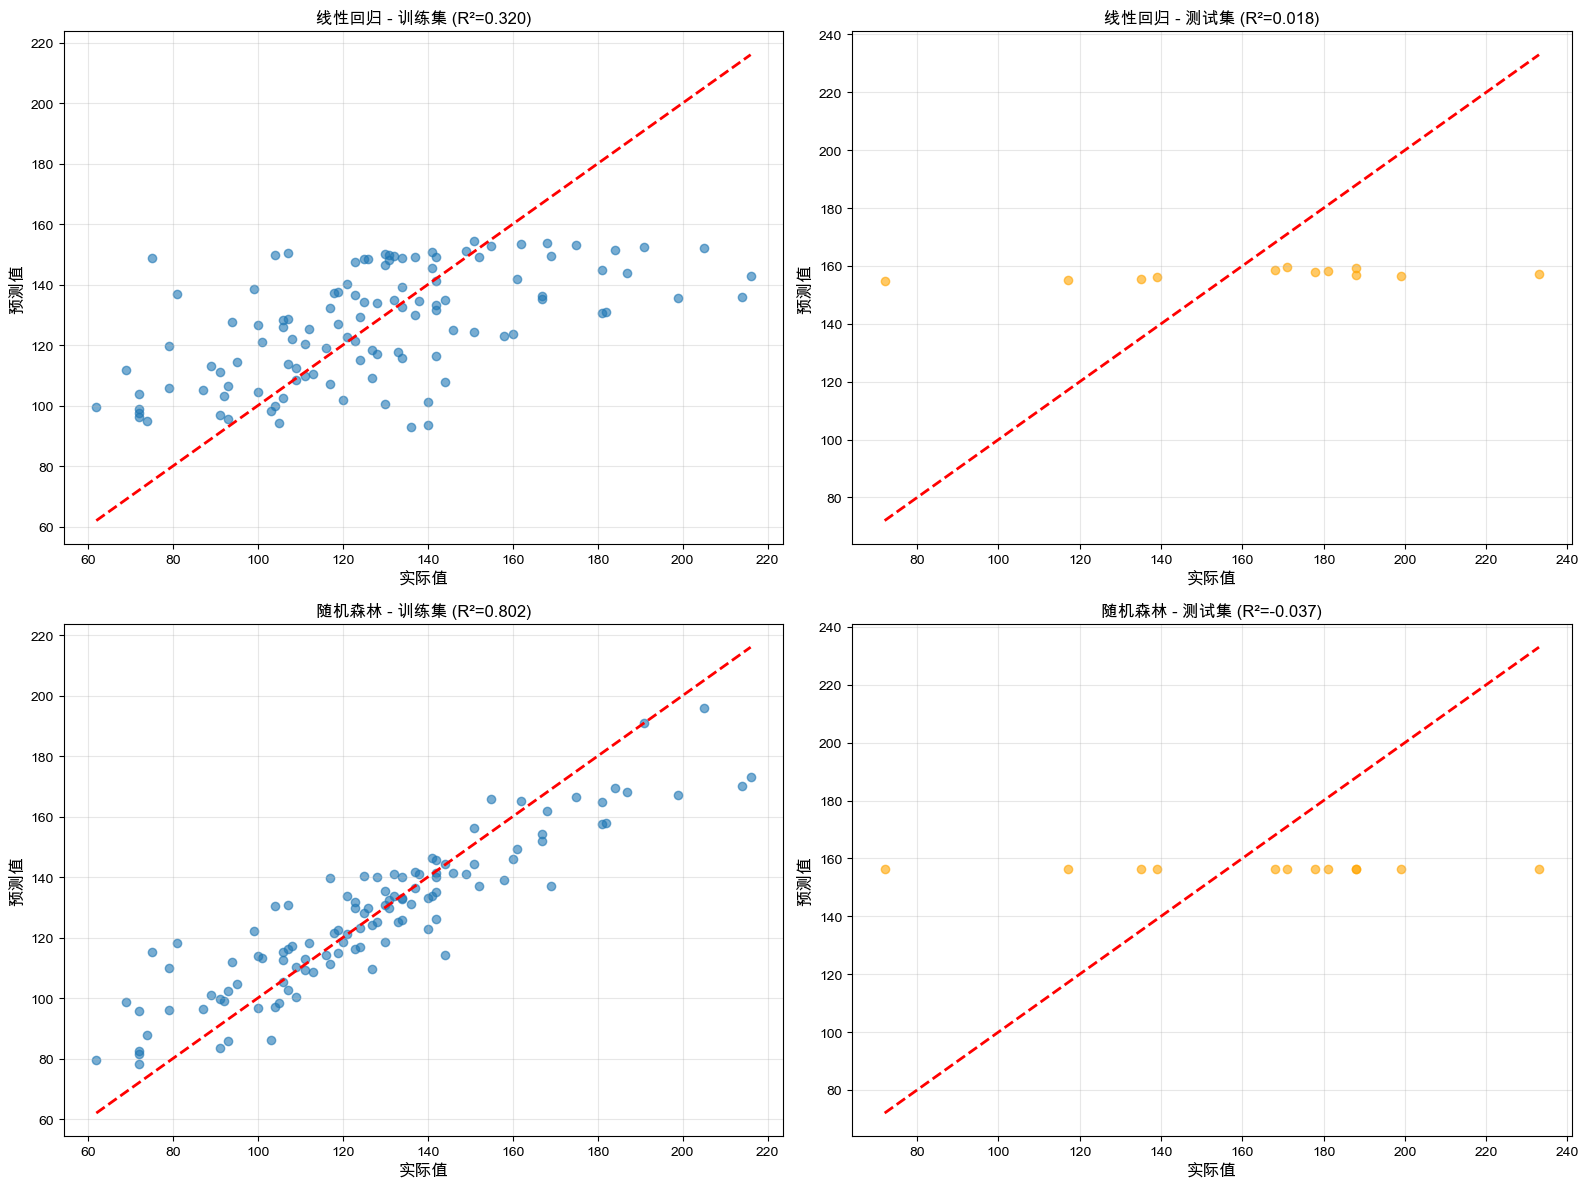

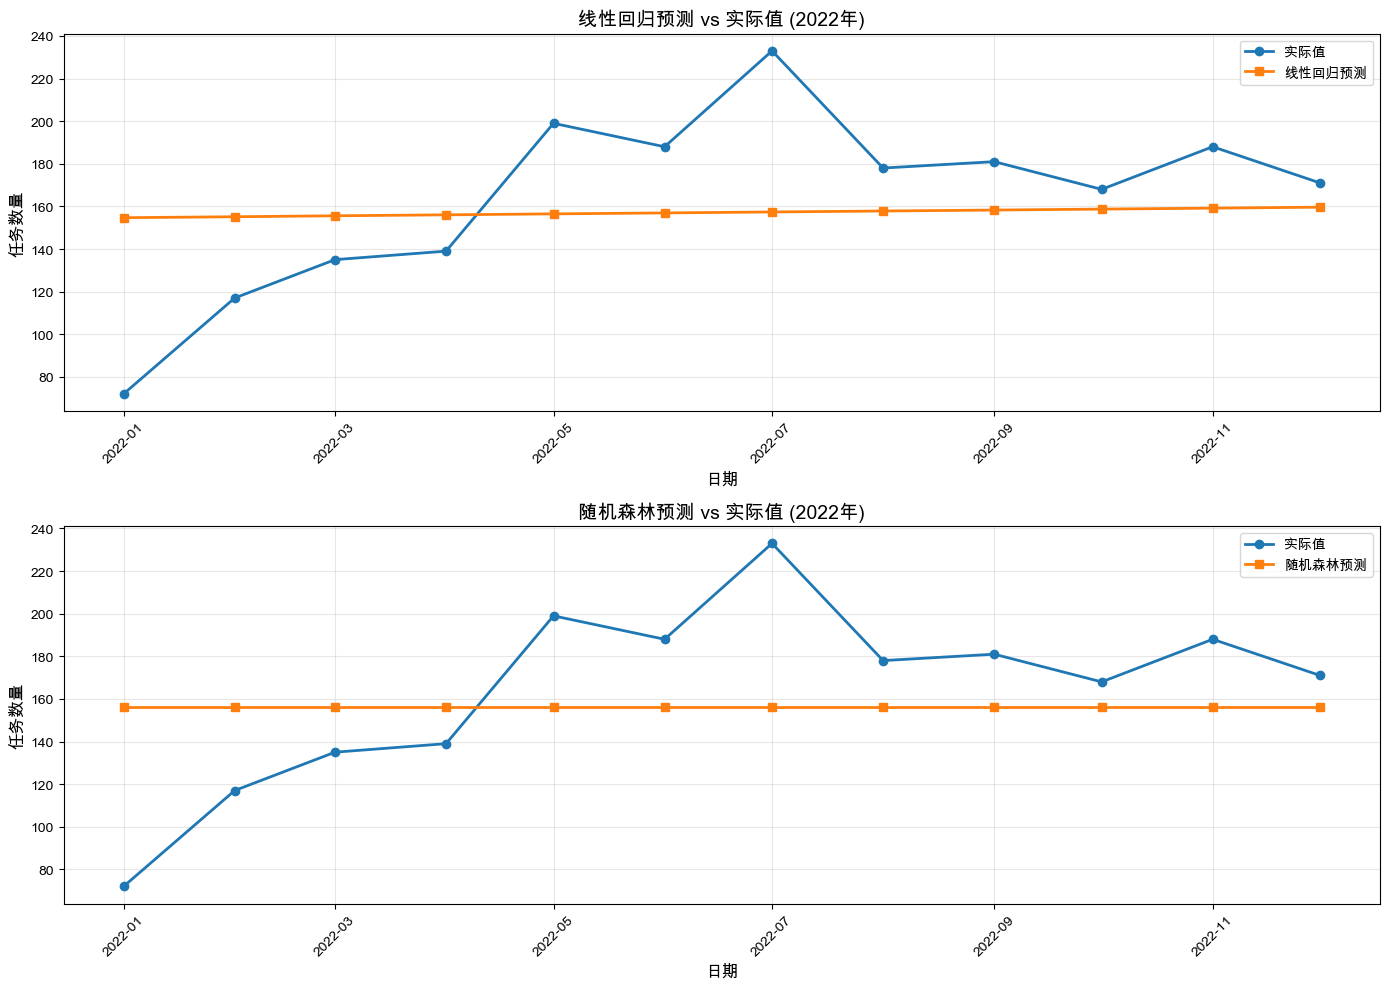

In [ ]:
from sklearn.preprocessing import StandardScaler

# 准备特征和目标变量
X = merged_data[['population_millions']].values
y = merged_data['count'].values

# 划分训练集和测试集（使用2022年作为测试集）
train_mask = merged_data['date'].dt.year < 2022
test_mask = merged_data['date'].dt.year == 2022

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

print(f"训练集: {len(X_train)} 个月 ({merged_data[train_mask]['date'].min()} 到 {merged_data[train_mask]['date'].max()})")
print(f"测试集: {len(X_test)} 个月 ({merged_data[test_mask]['date'].min()} 到 {merged_data[test_mask]['date'].max()})")

# 标准化特征（可选，对于线性回归通常不需要，但有助于比较）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 模型1: 线性回归
print("\n" + "="*60)
print("模型1: 线性回归")
print("="*60)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 预测
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# 评估
train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
train_r2_lr = r2_score(y_train, y_train_pred_lr)

test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
test_r2_lr = r2_score(y_test, y_test_pred_lr)

print(f"\n训练集评估:")
print(f"  MAE: {train_mae_lr:.2f}")
print(f"  RMSE: {train_rmse_lr:.2f}")
print(f"  R²: {train_r2_lr:.4f}")

print(f"\n测试集评估 (2022年):")
print(f"  MAE: {test_mae_lr:.2f}")
print(f"  RMSE: {test_rmse_lr:.2f}")
print(f"  R²: {test_r2_lr:.4f}")

print(f"\n模型系数:")
print(f"  斜率: {lr_model.coef_[0]:.2f} (每增加100万人，任务数增加 {lr_model.coef_[0]*100:.2f})")
print(f"  截距: {lr_model.intercept_:.2f}")

# 模型2: 随机森林回归
print("\n" + "="*60)
print("模型2: 随机森林回归")
print("="*60)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
rf_model.fit(X_train, y_train)

# 预测
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# 评估
train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
train_r2_rf = r2_score(y_train, y_train_pred_rf)

test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print(f"\n训练集评估:")
print(f"  MAE: {train_mae_rf:.2f}")
print(f"  RMSE: {train_rmse_rf:.2f}")
print(f"  R²: {train_r2_rf:.4f}")

print(f"\n测试集评估 (2022年):")
print(f"  MAE: {test_mae_rf:.2f}")
print(f"  RMSE: {test_rmse_rf:.2f}")
print(f"  R²: {test_r2_rf:.4f}")

# 可视化预测结果
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 线性回归 - 训练集
axes[0, 0].scatter(y_train, y_train_pred_lr, alpha=0.6)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('实际值', fontsize=12)
axes[0, 0].set_ylabel('预测值', fontsize=12)
axes[0, 0].set_title(f'线性回归 - 训练集 (R²={train_r2_lr:.3f})', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 线性回归 - 测试集
axes[0, 1].scatter(y_test, y_test_pred_lr, alpha=0.6, color='orange')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('实际值', fontsize=12)
axes[0, 1].set_ylabel('预测值', fontsize=12)
axes[0, 1].set_title(f'线性回归 - 测试集 (R²={test_r2_lr:.3f})', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 随机森林 - 训练集
axes[1, 0].scatter(y_train, y_train_pred_rf, alpha=0.6)
axes[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('实际值', fontsize=12)
axes[1, 0].set_ylabel('预测值', fontsize=12)
axes[1, 0].set_title(f'随机森林 - 训练集 (R²={train_r2_rf:.3f})', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 随机森林 - 测试集
axes[1, 1].scatter(y_test, y_test_pred_rf, alpha=0.6, color='orange')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('实际值', fontsize=12)
axes[1, 1].set_ylabel('预测值', fontsize=12)
axes[1, 1].set_title(f'随机森林 - 测试集 (R²={test_r2_rf:.3f})', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 时间序列可视化
test_dates = merged_data[test_mask]['date'].values

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 线性回归预测
axes[0].plot(test_dates, y_test, 'o-', label='实际值', linewidth=2, markersize=6)
axes[0].plot(test_dates, y_test_pred_lr, 's-', label='线性回归预测', linewidth=2, markersize=6)
axes[0].set_title('线性回归预测 vs 实际值 (2022年)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('日期', fontsize=12)
axes[0].set_ylabel('任务数量', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# 随机森林预测
axes[1].plot(test_dates, y_test, 'o-', label='实际值', linewidth=2, markersize=6)
axes[1].plot(test_dates, y_test_pred_rf, 's-', label='随机森林预测', linewidth=2, markersize=6)
axes[1].set_title('随机森林预测 vs 实际值 (2022年)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('日期', fontsize=12)
axes[1].set_ylabel('任务数量', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

# 设置中文字体（macOS）
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'STHeiti', 'PingFang SC']
plt.rcParams['axes.unicode_minus'] = False  


In [74]:
df_master = pd.read_csv('refer data/FlightTransportsMaster.csv')

In [76]:
df_master

,tdate,putime,disptime,enrtime,atstime,tratime,atdtime,yearwithrc,Call Type,veh,...,Charts Transports FY 13 14_Receiving,Receiving Hospital Unit,Rec City,Rec State,Age Range,Weight,Medical,Outcome,Transported,TASC Primary Asset
0,08/1/2021,8/1/2021 20:02:00,8/1/2021 20:03:22,8/1/2021 21:27:09,8/1/2021 22:05:23,8/2/2021 00:30:08,8/2/2021 01:12:54,21-30137,LOM FIXED WING,LF3,...,Eastern Maine Medical Center,Neonatal ICU,Bangor,Maine,0-1,3.5,Neonatal,Transported Patient,Yes,LF3
1,08/3/2021,8/3/2021 11:41:37,8/3/2021 11:44:21,8/3/2021 12:16:21,8/3/2021 13:04:20,8/3/2021 14:39:29,8/3/2021 15:28:14,21-30389,NL Neonate,NEO49,...,Eastern Maine Medical Center,Neonatal ICU,Bangor,Maine,0-1,2.7,Neonatal,Transported Patient,Yes,neoGround
2,08/7/2021,8/7/2021 03:08:01,8/7/2021 03:10:21,8/7/2021 03:43:33,8/7/2021 04:31:42,8/7/2021 06:29:05,8/7/2021 07:16:19,21-30971,NL Neonate,NEO49,...,Eastern Maine Medical Center,Neonatal ICU,Bangor,Maine,0-1,4.7,Neonatal,Transported Patient,Yes,LF1
3,08/10/2021,8/10/2021 10:24:01,8/10/2021 10:24:27,8/10/2021 11:05:06,8/10/2021 11:57:35,8/10/2021 13:14:48,8/10/2021 14:03:45,21-31349,LOM INTERFACILITY,LF1,...,Eastern Maine Medical Center,Neonatal ICU,Bangor,Maine,0-1,2.6,Neonatal,Transported Patient,Yes,LF1
4,08/12/2021,8/12/2021 09:22:00,8/12/2021 09:22:28,8/12/2021 09:54:00,8/12/2021 11:09:51,8/12/2021 12:29:59,8/12/2021 13:40:39,21-31660,NL Neonate,NEO49,...,Eastern Maine Medical Center,Neonatal ICU,Bangor,Maine,0-1,4.4,Neonatal,Transported Patient,Yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7817,07/16/2024,7/16/2024 14:45:58,7/16/2024 14:46:23,7/16/2024 15:07:02,7/16/2024 15:19:10,7/16/2024 15:52:39,7/16/2024 16:04:29,24-36218,LOM SCENE,LF4,...,MaineHealth Maine Medical Center Portland,NaN,Portland,ME,44,176.4,Trauma,Transport by This EMS Unit (This Crew Only),Yes,LF4
7818,07/31/2024,7/31/2024 14:14:07,7/31/2024 14:15:15,7/31/2024 14:20:48,7/31/2024 14:40:55,7/31/2024 14:57:44,7/31/2024 15:14:51,24-39189,LOM CCT GROUND - NO BILL,LF10,...,EASTERN MAINE MEDICAL CENTER,NaN,Bangor,ME,32,242.5,Trauma,"Transport by Another EMS Unit, with a Member o...",Yes,LF1
7819,8/31/2024,8/31/2024 18:08:48,8/31/2024 18:09:35,8/31/2024 18:20:00,8/31/2024 18:38:01,8/31/2024 19:08:40,8/31/2024 19:23:59,24-45343,LOM SCENE,LF2,...,EASTERN MAINE MEDICAL CENTER,NaN,Bangor,ME,29,220.5,Trauma,Transport by This EMS Unit (This Crew Only),Yes,LF2
7820,02/23/2022,14:40:16,14:41:25,14:48:40,15:21:00,16:03:00,16:45:20,22-06946,NL CCT,B-CCT,...,Eastern Maine Medical Center,Emergency Department,Bangor,Maine,64,112,Traumatic Injury,Transported Patient,Yes,LF1


In [91]:
df_master

,tdate,putime,disptime,enrtime,atstime,tratime,atdtime,yearwithrc,Call Type,veh,...,Charts Transports FY 13 14_Receiving,Receiving Hospital Unit,Rec City,Rec State,Age Range,Weight,Medical,Outcome,Transported,TASC Primary Asset
0,2021-08-01,8/1/2021 20:02:00,8/1/2021 20:03:22,8/1/2021 21:27:09,8/1/2021 22:05:23,8/2/2021 00:30:08,8/2/2021 01:12:54,21-30137,LOM FIXED WING,LF3,...,Eastern Maine Medical Center,Neonatal ICU,Bangor,Maine,0-1,3.5,Neonatal,Transported Patient,Yes,LF3
1,2021-08-03,8/3/2021 11:41:37,8/3/2021 11:44:21,8/3/2021 12:16:21,8/3/2021 13:04:20,8/3/2021 14:39:29,8/3/2021 15:28:14,21-30389,NL Neonate,NEO49,...,Eastern Maine Medical Center,Neonatal ICU,Bangor,Maine,0-1,2.7,Neonatal,Transported Patient,Yes,neoGround
2,2021-08-07,8/7/2021 03:08:01,8/7/2021 03:10:21,8/7/2021 03:43:33,8/7/2021 04:31:42,8/7/2021 06:29:05,8/7/2021 07:16:19,21-30971,NL Neonate,NEO49,...,Eastern Maine Medical Center,Neonatal ICU,Bangor,Maine,0-1,4.7,Neonatal,Transported Patient,Yes,LF1
3,2021-08-10,8/10/2021 10:24:01,8/10/2021 10:24:27,8/10/2021 11:05:06,8/10/2021 11:57:35,8/10/2021 13:14:48,8/10/2021 14:03:45,21-31349,LOM INTERFACILITY,LF1,...,Eastern Maine Medical Center,Neonatal ICU,Bangor,Maine,0-1,2.6,Neonatal,Transported Patient,Yes,LF1
4,2021-08-12,8/12/2021 09:22:00,8/12/2021 09:22:28,8/12/2021 09:54:00,8/12/2021 11:09:51,8/12/2021 12:29:59,8/12/2021 13:40:39,21-31660,NL Neonate,NEO49,...,Eastern Maine Medical Center,Neonatal ICU,Bangor,Maine,0-1,4.4,Neonatal,Transported Patient,Yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7817,2024-07-16,7/16/2024 14:45:58,7/16/2024 14:46:23,7/16/2024 15:07:02,7/16/2024 15:19:10,7/16/2024 15:52:39,7/16/2024 16:04:29,24-36218,LOM SCENE,LF4,...,MaineHealth Maine Medical Center Portland,NaN,Portland,ME,44,176.4,Trauma,Transport by This EMS Unit (This Crew Only),Yes,LF4
7818,2024-07-31,7/31/2024 14:14:07,7/31/2024 14:15:15,7/31/2024 14:20:48,7/31/2024 14:40:55,7/31/2024 14:57:44,7/31/2024 15:14:51,24-39189,LOM CCT GROUND - NO BILL,LF10,...,EASTERN MAINE MEDICAL CENTER,NaN,Bangor,ME,32,242.5,Trauma,"Transport by Another EMS Unit, with a Member o...",Yes,LF1
7819,2024-08-31,8/31/2024 18:08:48,8/31/2024 18:09:35,8/31/2024 18:20:00,8/31/2024 18:38:01,8/31/2024 19:08:40,8/31/2024 19:23:59,24-45343,LOM SCENE,LF2,...,EASTERN MAINE MEDICAL CENTER,NaN,Bangor,ME,29,220.5,Trauma,Transport by This EMS Unit (This Crew Only),Yes,LF2
7820,2022-02-23,14:40:16,14:41:25,14:48:40,15:21:00,16:03:00,16:45:20,22-06946,NL CCT,B-CCT,...,Eastern Maine Medical Center,Emergency Department,Bangor,Maine,64,112,Traumatic Injury,Transported Patient,Yes,LF1


In [81]:
df_master['tdate'] = pd.to_datetime(df_master['tdate'])
df_master_monthly = df_master.groupby(df_master['tdate'].dt.to_period('M')).size().reset_index(name='count')
df_master_monthly['date'] = df_master_monthly['tdate'].astype(str) + '-01'
df_master_monthly['date'] = pd.to_datetime(df_master_monthly['date'])
df_master_monthly = df_master_monthly[['date', 'count']].sort_values('date').reset_index(drop=True)

In [82]:
df_master_monthly

,date,count
0,2021-08-01,225
1,2021-09-01,229
2,2021-10-01,217
3,2021-11-01,205
4,2021-12-01,212
5,2022-01-01,153
6,2022-02-01,167
7,2022-03-01,198
8,2022-04-01,189
9,2022-05-01,230


In [90]:
monthly_data[(monthly_data['date']>='2021-08-01') & (monthly_data['date']<='2024-08-01')]

,date,count
109,2021-08-01,155
110,2021-09-01,175
111,2021-10-01,162
112,2021-11-01,168
113,2021-12-01,151
114,2022-01-01,72
115,2022-02-01,117
116,2022-03-01,135
117,2022-04-01,139
118,2022-05-01,199


In [89]:
monthly_data['date']

0     2012-07-01
1     2012-08-01
2     2012-09-01
3     2012-10-01
4     2012-11-01
         ...    
133   2023-08-01
134   2023-09-01
135   2023-10-01
136   2023-11-01
137   2023-12-01
Name: date, Length: 138, dtype: datetime64[ns]

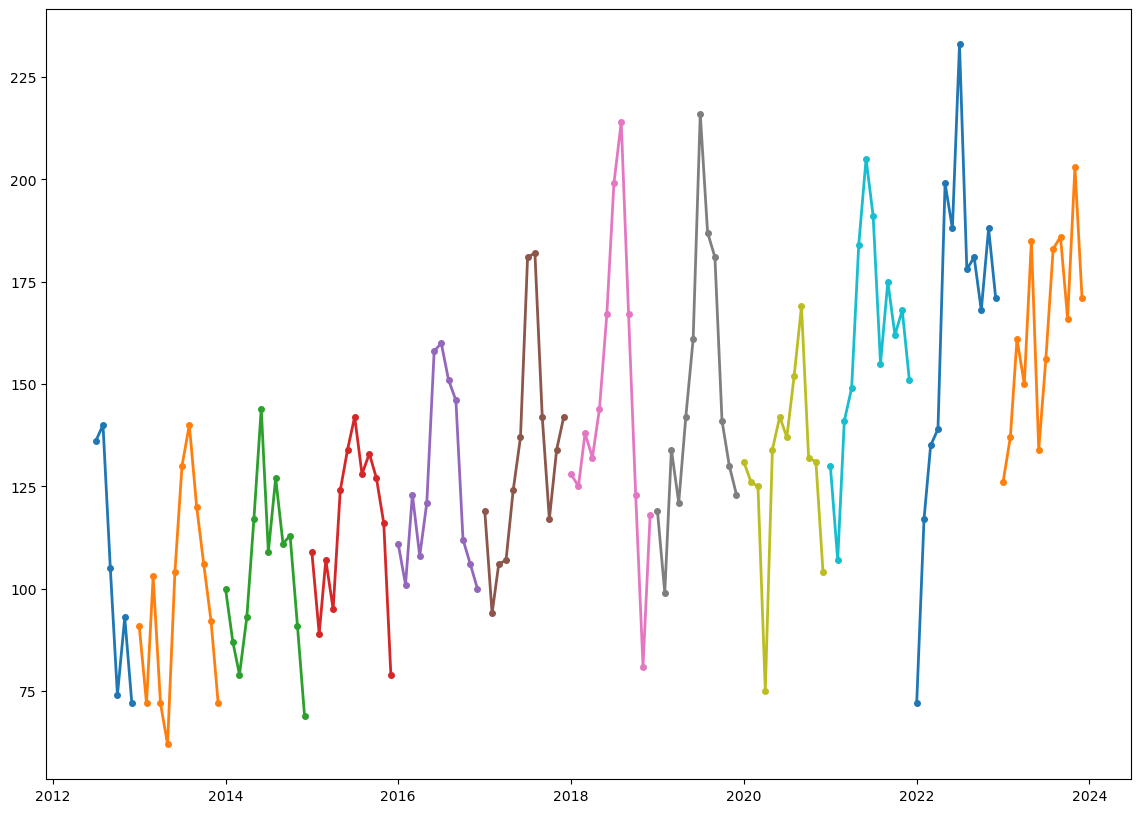

In [ ]:
plt.figure(figsize=(14, 10))
for year in range(2012, 2024):
    df_year = monthly_data[monthly_data['date'].dt.year == year]
    plt.plot(df_year['date'], df_year['count'], marker='o', linewidth=2, markersize=4)
plt.show()